# Importing necessary libraries

In [2]:
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import sklearn

from sklearn import linear_model
from sklearn import decomposition
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from smt.sampling_methods import LHS

import time
import datetime
import random
import csv
import os
import copy
import json
from tqdm import tqdm



/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [3]:
import tensorflow as tf
from Ura_model import *
from Glu_model import *

/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages

/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yshen/miniconda3/envs/AL/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yshen/miniconda3/envs/AL/lib/py

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





2025-03-30 15:32:03.427193: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


In [4]:
#test whether the model is implemented
sequence=["GCACTATGCGAATAGTTTTATAAGTTGTTAGCGTCGATGTCTTTCATTAAGTAGTGACGGGAGAAAAAGAGAAACTGTGA","GAGGCCACTGTAAATAATGGTCAGAAGTGTTGTTATGACACTTTGCAAGGGTGTCTCCCAGTGTAGCGCCTCTCGCCCTA"]
result=Ura_surrogate(sequence)
print(result)

start test!
1024/1024 [==============================] - 1s 1ms/sample
[6.85928912 4.10611823]


In [6]:
def noisy_surrogate(sequence):
    result=Ura_surrogate(sequence)
    for i in range(len(result)):
        result[i]= np.random.normal(result[i],result[i]*0.05, 1)[0]
    return result

def very_noisy_surrogate(sequence):
    result=Ura_surrogate(sequence)
    for i in range(len(result)):
        result[i]= np.random.normal(result[i],result[i]*0.10, 1)[0]
    return result


# Utility functions

In [7]:
def random_sampling(num):
    x = np.random.random_sample((num,80))
    sequence_list=[]
    for i in range(num):
        oh=""
        for j in range(80):
            if x[i][j]<0.25:
                oh=oh+"A"
            elif x[i][j]<0.5:
                oh=oh+"C"
            elif x[i][j]<0.75:
                oh=oh+"G"
            elif x[i][j]<1:
                oh=oh+"T"             
        sequence_list.append(oh)
    return sequence_list

In [5]:
import numpy as np

def convert_input_type(seq, target_type):
    """
    Convert DNA sequence between string and one-hot encoded representations.

    Args:
        seq: The input DNA sequence(s).
        target_type: The target representation type ("one_hot" or "strings").

    Returns:
        The converted DNA sequence(s).
    """
    if target_type == "one_hot":
        # Convert string to one-hot encoded numpy array
        mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
        one_hot = np.array([mapping[base] for base in seq])
        return one_hot
    elif target_type == "strings":
        # Convert one-hot encoded numpy array to string
        mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
        strings = ''.join([mapping[np.argmax(base)] for base in seq])
        return strings
    else:
        raise ValueError("Unsupported target_type. Use 'one_hot' or 'strings'.")

In [ ]:
# Gradient Descent

import numpy as np

from typing import Optional, Callable, List

def convert_input_type(seq, target_type):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    if target_type == "one_hot":
        one_hot = np.array([mapping[base] for base in seq]).flatten()
        return one_hot
    elif target_type == "strings":
        reverse_mapping = {tuple(v): k for k, v in mapping.items()}
        reshaped_seq = seq.reshape(-1, 4)
        strings = ''.join([reverse_mapping[tuple(base)] for base in reshaped_seq])
        return strings
    else:
        raise ValueError("Unsupported target_type. Use 'one_hot' or 'strings'.")

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def closest_one_hot(x):
    one_hot = np.zeros_like(x)
    one_hot[np.argmax(x)] = 1
    return one_hot

def gradient_descent_optimization(
    seq: str,
    model: MLPRegressor,
    loss_func: Callable,
    learning_rate: float = 0.1,
    max_iter: int = 100,
    positions: Optional[List[int]] = None,
    grad_clip: float = 1.0,
):
    """
    Sequence design using gradient descent optimization with MLPRegressor

    Args:
        seq: an initial DNA sequence as a string.
        model: A trained MLPRegressor object
        loss_func: A function to compute the loss
        learning_rate: Learning rate for gradient descent
        max_iter: Number of iterations
        positions: Positions to mutate. If None, all positions will be mutated
        grad_clip: Gradient clipping value

    Returns:
        Optimized DNA sequence as a string and its prediction value.
    """
    # Convert sequence into a one-hot encoded tensor
    X = convert_input_type(seq, "one_hot").reshape(1, -1).astype(float)
    print(f"Initial shape of X: {X.shape}")

    best_X = X.copy()
    best_y = model.predict(X)
    best_loss = loss_func(best_y)
    print(f"Initial loss: {best_loss}")

    # Gradient descent optimization
    for i in range(max_iter):
        # Forward pass
        y_pred = model.predict(X)
        
        # Compute loss
        loss = loss_func(y_pred)
        
        # Update best sequence if current loss is better
        if loss < best_loss:
            best_loss = loss
            best_X = X.copy()
            best_y = y_pred
        
        # Compute gradient (using numerical approximation)
        grad = np.zeros_like(X)
        epsilon = 1e-5
        for j in range(X.shape[1]):
            X_plus = X.copy()
            X_plus[0, j] += epsilon
            y_pred_plus = model.predict(X_plus)
            loss_plus = loss_func(y_pred_plus)
            grad[0, j] = (loss_plus - loss) / epsilon
        
        # Clip gradients
        grad = np.clip(grad, -grad_clip, grad_clip)
        
        # Update X using gradient descent
        X -= learning_rate * grad
        
        # Apply softmax normalization to each 4-element segment
        if np.mean(X)>2:
            for k in range(0, X.shape[1], 4):
                X[0, k:k+4] = softmax(X[0, k:k+4])
        
        # Print best sequence and prediction every 2 iterations
        if i % 2 == 0:
            # Convert best_X to closest one-hot vectors
            best_X_closest = best_X.copy()
            for k in range(0, best_X_closest.shape[1], 4):
                best_X_closest[0, k:k+4] = closest_one_hot(best_X_closest[0, k:k+4])
            best_seq = convert_input_type(best_X_closest.reshape(-1, 4), "strings")
            best_y_pred = model.predict(best_X_closest)  # Get the prediction of the best_X_closest
            # print(f"Iteration {i}, Best sequence: {best_seq}, Best prediction value: {best_y_pred}")

    # Convert best one-hot encoded array back to closest one-hot vectors
    for k in range(0, best_X.shape[1], 4):
        best_X[0, k:k+4] = closest_one_hot(best_X[0, k:k+4])
    
    best_y_pred = model.predict(best_X)  # Get the prediction of the best_X_closest
    print(f"Final loss: {best_y_pred}")


    # Convert optimized one-hot encoded array back to DNA sequence
    optimized_seq = convert_input_type(best_X.reshape(-1, 4), "strings")
    return optimized_seq, best_y_pred



In [ ]:
# SSWM
import numpy as np
from sklearn.neural_network import MLPRegressor
from typing import Callable, List
import random

def convert_input_type(seq, target_type):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    if target_type == "one_hot":
        one_hot = np.array([mapping[base] for base in seq]).flatten()
        return one_hot
    elif target_type == "strings":
        reverse_mapping = {tuple(v): k for k, v in mapping.items()}
        reshaped_seq = seq.reshape(-1, 4)
        strings = ''.join([reverse_mapping[tuple(base)] for base in reshaped_seq])
        return strings
    else:
        raise ValueError("Unsupported target_type. Use 'one_hot' or 'strings'.")

def mutate_sequence(seq: str, mutation_rate: float = 0.1) -> str:
    bases = ['A', 'C', 'G', 'T']
    mutated_seq = list(seq)
    for i in range(len(seq)):
        if random.random() < mutation_rate:
            mutated_seq[i] = random.choice(bases)
    return ''.join(mutated_seq)

def SSWM_optimization(
    seq: str,
    model: MLPRegressor,
    loss_func: Callable,
    population_size: int = 10,
    generations: int = 100,
    mutation_rate: float = 0.1,
):
    """
    Sequence design using SSWM with MLPRegressor

    Args:
        seq: an initial DNA sequence as a string.
        model: A trained MLPRegressor object
        loss_func: A function to compute the loss
        population_size: Number of sequences in the population
        generations: Number of generations to evolve
        mutation_rate: Probability of mutating each base in the sequence

    Returns:
        Optimized DNA sequence as a string and its prediction value.
    """
    # Initialize population with the initial sequence
    population = [seq] * population_size
    best_seq = seq
    best_y = model.predict(convert_input_type(seq, "one_hot").reshape(1, -1))
    best_loss = loss_func(best_y)
    print(f"Initial sequence: {seq}, Initial loss: {best_loss}")

    for generation in range(generations):
        # Mutate population
        new_population = [mutate_sequence(seq, mutation_rate) for seq in population]
        
        # Evaluate fitness of the new population
        fitness_scores = []
        for new_seq in new_population:
            X = convert_input_type(new_seq, "one_hot").reshape(1, -1).astype(float)
            y_pred = model.predict(X)
            loss = loss_func(y_pred)
            fitness_scores.append((new_seq, y_pred, loss))
        
        # Select the best sequence in the current generation
        fitness_scores.sort(key=lambda x: x[2])  # Sort by loss (ascending)
        current_best_seq, current_best_y, current_best_loss = fitness_scores[0]
        
        # Update global best sequence if current best is better
        if current_best_loss < best_loss:
            best_seq = current_best_seq
            best_y = current_best_y
            best_loss = current_best_loss
        
        # Update population with the top sequences
        population = [seq for seq, _, _ in fitness_scores[:population_size]]
        
        print(f"Generation {generation}, Best sequence: {best_seq}, Best prediction value: {best_y}, Best loss: {best_loss}")

    return best_seq, best_y


# Get optimal sequences

In [ ]:
import pandas as pd
import numpy as np

class PromoterModel:
    def __init__(self):
        self.model = None

    def get_sampling(self, n_samples):
        
        sample_X = initial_sampling[:n_samples]
        return sample_X

    def build_model(self, sample_X):
        onehot_X = [convert_input_type(i, "one_hot") for i in sample_X]
        y = Ura_surrogate(sample_X)
        
        # Define the parameter grid
        param_grid = {
            'hidden_layer_sizes': [
                (10,),
                (40, 10),
                (100, 100, 20),
                (10, 100, 100, 20)
            ]
        }
        
        # Initialize the MLPRegressor
        mlp = MLPRegressor(max_iter=1000, random_state=0)
        
        # Use GridSearchCV to perform 5-fold cross-validation
        grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='r2')
        
        # Fit the model
        grid_search.fit(onehot_X, y)
        
        # Select the best model
        self.model = grid_search.best_estimator_

    def loss_func(self, y_pred):
        return -np.mean(y_pred)

    def get_model(self, n_samples):
        samples = self.get_sampling(n_samples)
        self.build_model(samples)
        return self.model

    def random_screening(self, sample_for_model=1000, n_screens=100000):
        model = self.get_model(sample_for_model)
        sequences = random_sampling(n_screens)
        evaluations = [(seq, model.predict(convert_input_type(seq, "one_hot").reshape(1, -1))) for seq in sequences]
        sorted_evaluations = sorted(evaluations, key=lambda x: x[1], reverse=True)

        top_100_sequences = sorted_evaluations[:100]
        top_sequences = [seq for seq, score in top_100_sequences]
        top_scores = [score[0] for seq, score in top_100_sequences]
        return top_sequences, top_scores

    def get_best_batch(self, sample_for_model=1000, batch_size=1000, method="gradient"):
        batch = []
        model = self.get_model(sample_for_model)
        j = 0
        while j < batch_size:
            print("time:" + time.time())
            seq = random_sampling(1)[0]
            if method == "gradient":
                optimized_seq, best_y_pred = gradient_descent_optimization(seq, model, self.loss_func)
            elif method == "SSWM":
                optimized_seq, best_y_pred = SSWM_optimization(seq, model, self.loss_func)
            if optimized_seq not in [item[0] for item in batch]:
                batch.append((optimized_seq, best_y_pred))
            j = j+1
        sequences = [item[0] for item in batch]
        expression_levels = np.array([item[1][0] for item in batch])
        return sequences, expression_levels
    

In [ ]:
conditions=["latin_uniform","rd1_uniform","rd2_uniform","latin_low","rd1_low","rd2_low"]
for condition in conditions:
    with open('initial_condition/initial_'+condition+'_4000.txt', 'r') as f:
        initial_sampling=json.load(f)
    sample_size = [1000, 2000, 3000, 4000]
    promoter_model = PromoterModel()
    dataframe_sequences = pd.DataFrame()
    # Loop through sample sizes and collect data
    for i in tqdm(sample_size):
        sequences, expression_levels = promoter_model.random_screening(sample_for_model=i, n_screens=100000)
        real_expression_levels = Ura_surrogate(sequences)
        dataframe_sequences["sequence"+str(i)] = sequences
        dataframe_sequences["evaluation"+str(i)] = expression_levels
        dataframe_sequences["real"+str(i)] = real_expression_levels
        print(np.mean(real_expression_levels))

    dataframe_sequences.to_csv('promoter_rd_'+condition+'.csv', index=False)


  0%|                                                     | 0/4 [00:00<?, ?it/s]

start test!
1024/1024 [==============================] - 1s 1ms/sample
start test!
1024/1024 [==============================] - 1s 1ms/sample



 25%|███████████▎                                 | 1/4 [01:09<03:27, 69.29s/it]

12.843767058079074
start test!
2048/2048 [==============================] - 2s 1ms/sample
start test!
1024/1024 [==============================] - 1s 1ms/sample



 50%|██████████████████████▌                      | 2/4 [02:47<02:52, 86.30s/it]

13.052852579833493
start test!
3072/3072 [==============================] - 4s 1ms/sample
start test!
1024/1024 [==============================] - 1s 1ms/sample



 75%|█████████████████████████████████           | 3/4 [04:56<01:45, 105.80s/it]

13.256077980469621
start test!
4096/4096 [==============================] - 5s 1ms/sample
start test!
1024/1024 [==============================] - 1s 1ms/sample


  0%|                                                     | 0/4 [00:00<?, ?it/s]

12.951588988201715
start test!
1024/1024 [==============================] - 1s 1ms/sample
start test!
1024/1024 [==============================] - 1s 1ms/sample



 25%|███████████▎                                 | 1/4 [01:01<03:03, 61.19s/it]

12.887186529794382
start test!
2048/2048 [==============================] - 2s 1ms/sample


In [ ]:
conditions=["latin_uniform","rd1_uniform","rd2_uniform","latin_low","rd1_low","rd2_low"]
for condition in conditions:
    with open('initial_condition/initial_'+condition+'_4000.txt', 'r') as f:
        initial_sampling=json.load(f)
    sample_size = [1000, 2000, 3000, 4000]
    promoter_model = PromoterModel()

    # Loop through sample sizes and collect data
    for i in tqdm(sample_size):
        print(i)
        sequences, expression_levels = promoter_model.get_best_batch(sample_for_model=i, batch_size=100, method="gradient")    
        real_expression_levels = Ura_surrogate(sequences)
        dataframe_sequences = pd.DataFrame()
        dataframe_sequences["sequence"+str(i)] = sequences
        dataframe_sequences["evaluation"+str(i)] = expression_levels
        dataframe_sequences["real"+str(i)] = real_expression_levels
        print(np.mean(real_expression_levels))
        # dataframe_sequences.to_csv('promoter_de'+str(i)+'_'+condition+'.csv', index=False)
        # dataframe_sequences.to_csv('promoter_gd'+str(i)+'_'+condition+'.csv', index=False)
    


  0%|          | 0/4 [00:00<?, ?it/s]

1000
start test!
1024/1024 [==============================] - 1s 956us/sample
1743345337.8118794
Initial shape of X: (1, 320)
Initial loss: -6.996059561223027
Final loss: [44.56377061]
1743345341.7536514
Initial shape of X: (1, 320)
Initial loss: -10.132171304281496
Final loss: [49.97080178]
1743345345.6862648
Initial shape of X: (1, 320)
Initial loss: -3.9355223761674276
Final loss: [46.70061083]
1743345349.6220384
Initial shape of X: (1, 320)
Initial loss: -11.118681729171733
Final loss: [45.68057614]
1743345353.557728
Initial shape of X: (1, 320)
Initial loss: -5.843245143392638
Final loss: [49.5753328]
1743345357.4903796
Initial shape of X: (1, 320)
Initial loss: -6.848691088728516
Final loss: [48.43006288]
1743345361.4281764
Initial shape of X: (1, 320)
Initial loss: -7.294911538780324
Final loss: [46.26932706]
1743345365.368549
Initial shape of X: (1, 320)
Initial loss: -3.721688815335244
Final loss: [47.87822432]
1743345369.3118432
Initial shape of X: (1, 320)
Initial loss: -7.8

 25%|██▌       | 1/4 [01:22<04:07, 82.61s/it]

13.809461339324438
2000
start test!
2048/2048 [==============================] - 2s 937us/sample


# Plotting

In [13]:
with open('data_ym_SMW_uniform_4000.txt', 'r') as f:
    smw_data = json.load(f)
with open('data_ym_SMW_uniform_motif.txt', 'r') as f:
    motif_data = json.load(f)
    
print(np.mean(smw_data[1]),np.mean(smw_data[2]),np.mean(smw_data[3]),np.mean(smw_data[4]))
print(np.mean(motif_data[1]),np.mean(motif_data[2]),np.mean(motif_data[3]),np.mean(motif_data[4]))

13.515898211053678 14.083217245617139 14.485926370078287 14.411452167967537
13.570110533591906 14.322982733328601 14.652904416293325 14.949873306553188


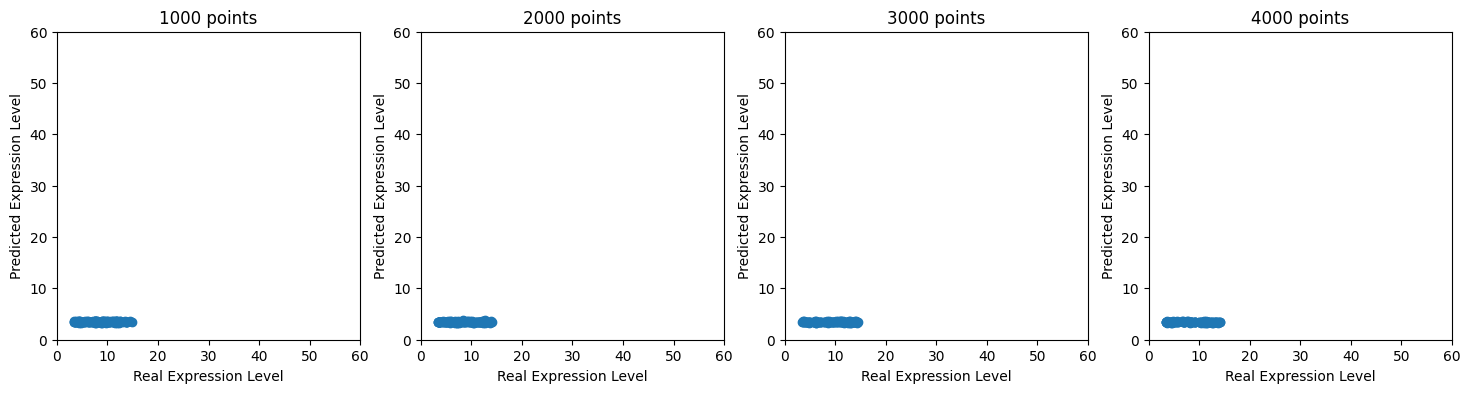

In [35]:
# scatter plot
import matplotlib.pyplot as plt
import pandas as pd

# Read data from CSV files
data1 = pd.read_csv("promoter_de1000_low.csv")
data2 = pd.read_csv("promoter_de2000_low.csv")
data3 = pd.read_csv("promoter_de3000_low.csv")
data4 = pd.read_csv("promoter_de4000_low.csv")


# Extract x and y values for each plot
x1, y1 = data1['real1000'], data1['evaluation1000']
x2, y2 = data2['real2000'], data2['evaluation2000']
x3, y3 = data3['real3000'], data3['evaluation3000']
x4, y4 = data4['real4000'], data4['evaluation4000']

# Create a figure and 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot scatter plots
axs[0].scatter(x1, y1)
axs[0].set_title('1000 points')
axs[0].set_xlabel('Real Expression Level')  
axs[0].set_ylabel('Predicted Expression Level')
axs[0].set_xlim(0, 60)
axs[0].set_ylim(0, 60)

axs[1].scatter(x2, y2)
axs[1].set_title('2000 points')
axs[1].set_xlabel('Real Expression Level')
axs[1].set_ylabel('Predicted Expression Level')
axs[1].set_xlim(0, 60)
axs[1].set_ylim(0, 60)

axs[2].scatter(x3, y3)
axs[2].set_title('3000 points')
axs[2].set_xlabel('Real Expression Level')
axs[2].set_ylabel('Predicted Expression Level')
axs[2].set_xlim(0, 60)
axs[2].set_ylim(0, 60)

axs[3].scatter(x4, y4)
axs[3].set_title('4000 points')
axs[3].set_xlabel('Real Expression Level')
axs[3].set_ylabel('Predicted Expression Level')
axs[3].set_xlim(0, 60)
axs[3].set_ylim(0, 60)

# Show the plot
plt.show()

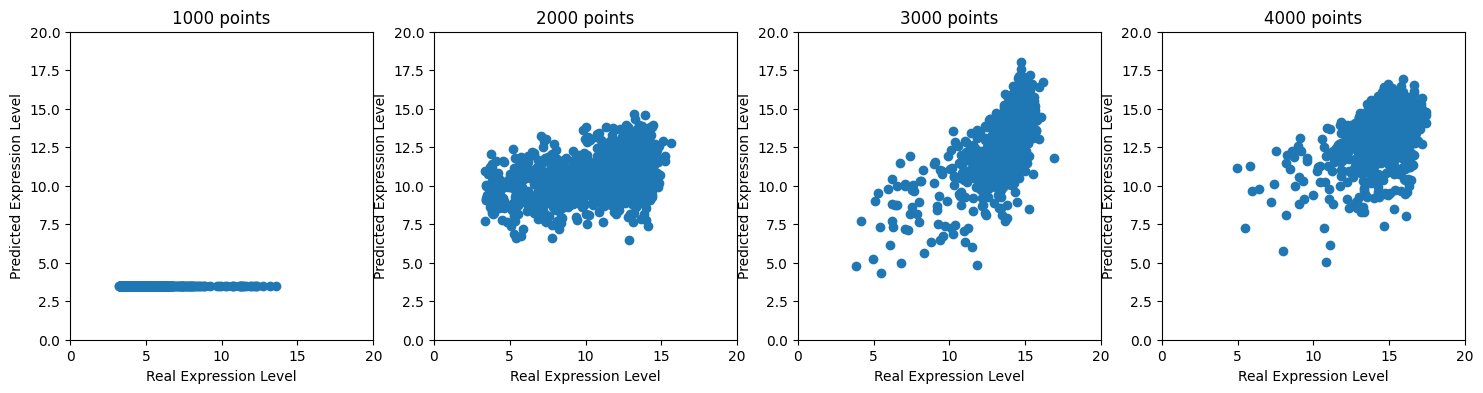

In [34]:
# scatter plot
import matplotlib.pyplot as plt
import pandas as pd

# Read data from CSV files
with open('data_ym_SMW_low_4000.txt', 'r') as f:
    ym = json.load(f)
with open('data_yp_SMW_low_4000.txt', 'r') as f:
    yp = json.load(f)

x1, y1 = ym[1], yp[0][-1000:]
x2, y2 = ym[2], yp[1][-1000:]
x3, y3 = ym[3], yp[2][-1000:]
x4, y4 = ym[4], yp[3][-1000:]

# Create a figure and 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot scatter plots
axs[0].scatter(x1, y1)
axs[0].set_title('1000 points')
axs[0].set_xlabel('Real Expression Level')  
axs[0].set_ylabel('Predicted Expression Level')
axs[0].set_xlim(0, 20)
axs[0].set_ylim(0, 20)

axs[1].scatter(x2, y2)
axs[1].set_title('2000 points')
axs[1].set_xlabel('Real Expression Level')
axs[1].set_ylabel('Predicted Expression Level')
axs[1].set_xlim(0, 20)
axs[1].set_ylim(0, 20)

axs[2].scatter(x3, y3)
axs[2].set_title('3000 points')
axs[2].set_xlabel('Real Expression Level')
axs[2].set_ylabel('Predicted Expression Level')
axs[2].set_xlim(0, 20)
axs[2].set_ylim(0, 20)

axs[3].scatter(x4, y4)
axs[3].set_title('4000 points')
axs[3].set_xlabel('Real Expression Level')
axs[3].set_ylabel('Predicted Expression Level')
axs[3].set_xlim(0, 20)
axs[3].set_ylim(0, 20)

# Show the plot
plt.show()

In [41]:
#sequence diversity
def hamming_distance(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strings must be of equal length")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def pairwise_hamming_distance(strings):
    distances = []
    for i in range(len(strings)):
        for j in range(i+1, len(strings)):
            distance = hamming_distance(strings[i], strings[j])
            distances.append(distance)
    return distances



In [58]:
# compute pairwise hamming distances
# random_sampling=pd.read_csv('promoter_rd_low.csv')


# data_X=[]
# for i in range(4):
#     data_X.append(random_sampling["sequence"+str(i+1)+"000"].tolist())


with open('data_X_SMW_low_4000.txt', 'r') as f:
    data_X= json.load(f)
pw=[]
for i in range(5):
    pw.append(pairwise_hamming_distance(data_X[i]))

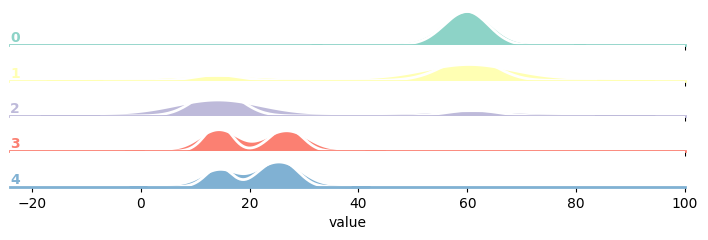

In [59]:
df = pd.DataFrame(pw).transpose()
df = df.melt(var_name='distribution', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(df, row='distribution', hue='distribution', aspect=15, height=0.5, palette='Set3')

# Map a kdeplot onto each facet
g.map(sns.kdeplot, 'value', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.4)
g.map(sns.kdeplot, 'value', clip_on=False, color='w', lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'value')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

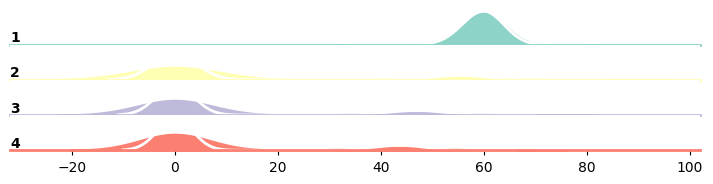

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'pw' is already defined
df = pd.DataFrame(pw).transpose()
df = df.melt(var_name='distribution', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(df, row='distribution', hue='distribution', aspect=15, height=0.5, palette='Set3')

# Map a kdeplot onto each facet
g.map(sns.kdeplot, 'value', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.4)
g.map(sns.kdeplot, 'value', clip_on=False, color='w', lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label, index):
    ax = plt.gca()
    ax.text(0, .2, str(index + 1), fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

# Map the label function with the index
for i, ax in enumerate(g.axes.flat):
    ax.text(0, .2, str(i + 1), fontweight="bold", color='black', 
            ha="left", va="center", transform=ax.transAxes)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Show the plot
plt.show()